In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching

In [66]:
# use original Sentinel-1 SAR files (download from colhub.met.no)
f1 = 'S1B_EW_GRDM_1SDH_20200123T120618_20200123T120718_019944_025BA1_D4A2.SAFE'
f2 = 'S1B_EW_GRDM_1SDH_20200125T114955_20200125T115055_019973_025C81_EC1A.SAFE'

# create Nansat objects with one band only (sigma0_HV by default)
n1 = get_n(f1)
n2 = get_n(f2)

/src/sea_ice_drift/lib.py:237: RuntimeWarning: divide by zero encountered in log10
  img = 10 * np.log10(img)
/src/sea_ice_drift/lib.py:43: RuntimeWarning: invalid value encountered in less
  uint8Image[uint8Image < 1] = 1
/src/sea_ice_drift/lib.py:44: RuntimeWarning: invalid value encountered in greater
  uint8Image[uint8Image > 255] = 255


In [67]:
# run Feature Tracking
# get start/end coordinates in the image coordinate system (rows/colums)  
c1, r1, c2, r2 = feature_tracking(n1, n2)

ORB detector initiated
Key points found: 100000
ORB detector initiated
Key points found: 100000
Domain filter: 100000 -> 94893
Domain filter: 100000 -> 99558
Keypoints matched 5.840276718139648
Ratio test 0.700000 found 20707 keypoints
MaxDrift filter: 20707 -> 20642
LSTSQ filter: 20642 -> 20557


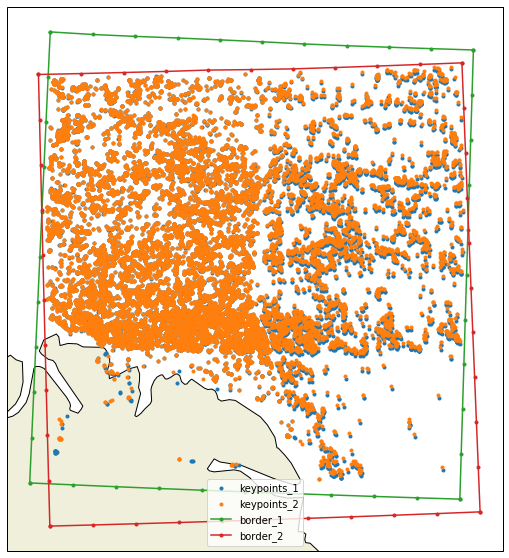

In [68]:
# Plot identified and matched keypoints in geographic coordinates
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

# get vector of lon/lat coordinates for the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

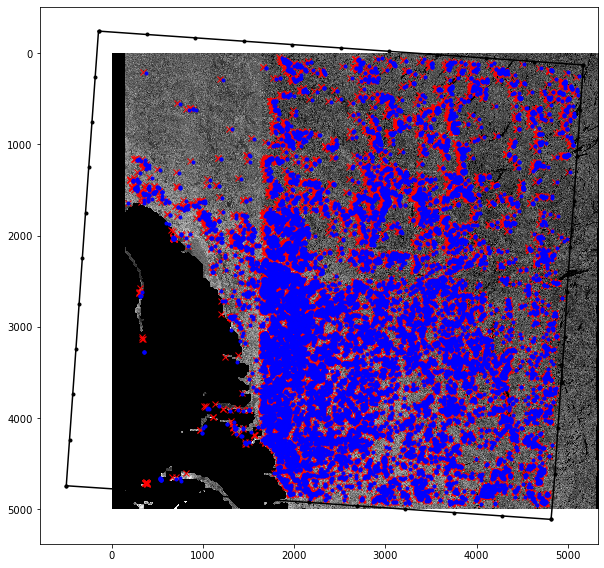

In [69]:
plt.figure(figsize=(10,10))
plt.imshow(n1[1], cmap='gray')
n1c2, n1r2 = n1.transform_points(*n2.transform_points(c2, r2), DstToSrc=1)
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)
plt.plot(c1, r1, 'rx')
plt.plot(n1c2, n1r2, 'b.')
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

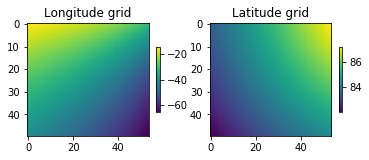

In [70]:
# Create longitude and latitude grids in 'swath' projection of the first image
step = 100
lon1pm, lat1pm = n1.get_geolocation_grids(stepSize=step)
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

In [71]:
# run pattern matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in degrees in geographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2)


 Pattern matching - OK! (  5 sec)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


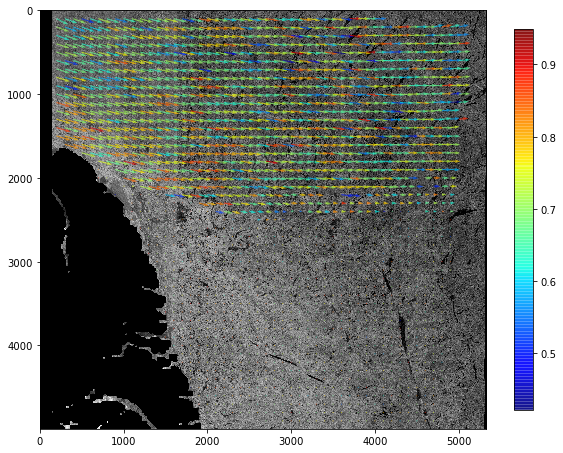

In [72]:
# plot results of pattern matching in image_1 coordinates

# find cells with quality over 4
gpi = hpm*rpm > 4

# convert lon/lat into image_1 coordinates (only valid pixels with high enough correlation)
c1pm, r1pm = n1.transform_points(lon1pm[gpi], lat1pm[gpi], DstToSrc=1)
c2pm, r2pm = n1.transform_points(lon2pm[gpi], lat2pm[gpi], DstToSrc=1)

# compute ice displacement [pix] in image_1 coordinates
dc_pm = c2pm - c1pm
dr_pm = r2pm - r1pm

# plot vectors of sea ice displacement from Feature Tracking, color by correlation
plt.figure(figsize=(10,10))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1pm, r1pm, dc_pm, dr_pm, rpm[gpi],
           angles='xy', scale_units='xy', scale=0.2, cmap='jet', alpha=0.7)
plt.colorbar(shrink=0.7)
plt.show()

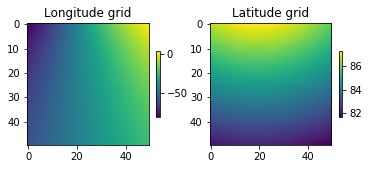

In [63]:
# Create lon/lat grids in Polar stereographic coordinate system 
# Extent of the grid roughly corresponds to the extent of the image_1

# projection (https://epsg.io/3413)
srs = NSR(3413)

# temporary grids of coordinates in swath projection
xgrdtmp, ygrdtmp = n1.get_geolocation_grids(100, dst_srs=srs)
d = Domain(srs.wkt, '-te %f %f %f %f -ts 50 50' % (
    xgrdtmp.min(),
    ygrdtmp.min(),
    xgrdtmp.max(),
    ygrdtmp.max()))

# lon/lat grids in polar stereographic projection covering image_1
lon1pm, lat1pm = d.get_geolocation_grids()
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

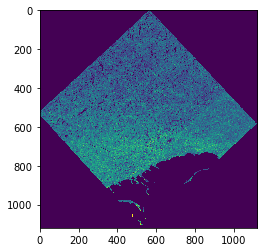

In [33]:
n1.reproject(d)
n1b1 = n1[1]
plt.imshow(n1b1)

In [64]:
# run pattern matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4())


 Pattern matching - OK! (  4 sec)


In [35]:
projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

In [49]:
x1pm.shape

(12, 12)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


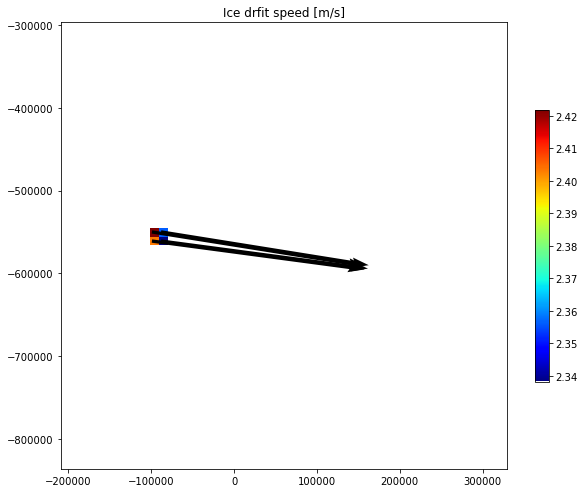

In [65]:
# compute ice drift speed [m/s]
delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
u = upm / delta_t
v = vpm / delta_t
spd = np.hypot(u,v)

# plot valid vectors in Polar stereographic projection
#watermask = Nansat.from_domain(d).watermask()[1]
gpi = (rpm > 0.4) #* (watermask < 2)
spd[~gpi] = np.nan
x1pm, y1pm = d.get_geolocation_grids(dst_srs=srs)

plt.figure(figsize=(10,10))
plt.imshow(spd, cmap='jet', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()])
plt.colorbar(shrink=0.5)
plt.quiver(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi], scale=5)
plt.title('Ice drfit speed [m/s]')
plt.show()

In [ ]:
## Generate test files for simple.py
"""
filenames = [
    'S1B_EW_GRDM_1SDH_20200123T120618_20200123T120718_019944_025BA1_D4A2.SAFE',
    'S1B_EW_GRDM_1SDH_20200125T114955_20200125T115055_019973_025C81_EC1A.SAFE'
]
crop_params = [
    [1800,4400,1000,1000],
    [2400,4600,1000,1000],
]

for f,c in zip(filenames, crop_params): 
    n = Nansat(f)
    n.reproject_gcps()
    n.vrt.tps = True
    n.crop(*crop_params)
    n.export(f[:32]+'.tif', bands=['sigma0_HV'], driver='GTiff')
"""